In [3625]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-approval-prediction/credit_record.csv
/kaggle/input/credit-card-approval-prediction/application_record.csv


# **Preprocessing**

**feature**

In [3626]:
df_feature = pd.read_csv('../input/credit-card-approval-prediction/application_record.csv',header=0)
df_feature

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [3627]:
df_feature.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [3628]:
df_feature.isnull().any()

ID                     False
CODE_GENDER            False
FLAG_OWN_CAR           False
FLAG_OWN_REALTY        False
CNT_CHILDREN           False
AMT_INCOME_TOTAL       False
NAME_INCOME_TYPE       False
NAME_EDUCATION_TYPE    False
NAME_FAMILY_STATUS     False
NAME_HOUSING_TYPE      False
DAYS_BIRTH             False
DAYS_EMPLOYED          False
FLAG_MOBIL             False
FLAG_WORK_PHONE        False
FLAG_PHONE             False
FLAG_EMAIL             False
OCCUPATION_TYPE         True
CNT_FAM_MEMBERS        False
dtype: bool

In [3629]:
df_feature.groupby('OCCUPATION_TYPE')['OCCUPATION_TYPE'].count()

OCCUPATION_TYPE
Accountants              15985
Cleaning staff            5845
Cooking staff             8076
Core staff               43007
Drivers                  26090
HR staff                   774
High skill tech staff    17289
IT staff                   604
Laborers                 78240
Low-skill Laborers        2140
Managers                 35487
Medicine staff           13520
Private service staff     3456
Realty agents             1041
Sales staff              41098
Secretaries               2044
Security staff            7993
Waiters/barmen staff      1665
Name: OCCUPATION_TYPE, dtype: int64

In [3630]:
df_feature_null = df_feature.dropna(axis=0)
df_feature_null.isnull().any()

ID                     False
CODE_GENDER            False
FLAG_OWN_CAR           False
FLAG_OWN_REALTY        False
CNT_CHILDREN           False
AMT_INCOME_TOTAL       False
NAME_INCOME_TYPE       False
NAME_EDUCATION_TYPE    False
NAME_FAMILY_STATUS     False
NAME_HOUSING_TYPE      False
DAYS_BIRTH             False
DAYS_EMPLOYED          False
FLAG_MOBIL             False
FLAG_WORK_PHONE        False
FLAG_PHONE             False
FLAG_EMAIL             False
OCCUPATION_TYPE        False
CNT_FAM_MEMBERS        False
dtype: bool

In [3631]:
df_feature_drop = df_feature_null.drop(['CODE_GENDER','DAYS_BIRTH','DAYS_EMPLOYED','FLAG_MOBIL','FLAG_WORK_PHONE','FLAG_EMAIL'],axis=1)
df_feature_drop.isnull().any()

ID                     False
FLAG_OWN_CAR           False
FLAG_OWN_REALTY        False
CNT_CHILDREN           False
AMT_INCOME_TOTAL       False
NAME_INCOME_TYPE       False
NAME_EDUCATION_TYPE    False
NAME_FAMILY_STATUS     False
NAME_HOUSING_TYPE      False
FLAG_PHONE             False
OCCUPATION_TYPE        False
CNT_FAM_MEMBERS        False
dtype: bool

In [3632]:
df_feature_clean = df_feature_drop
df_feature_clean.dtypes

ID                       int64
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
FLAG_PHONE               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
dtype: object

In [3633]:
df_feature_clean['FLAG_OWN_CAR'] = pd.factorize(df_feature_clean['FLAG_OWN_CAR'])[0]
df_feature_clean['FLAG_OWN_REALTY'] = pd.factorize(df_feature_clean['FLAG_OWN_REALTY'])[0]
df_feature_clean['NAME_INCOME_TYPE'] = pd.factorize(df_feature_clean['NAME_INCOME_TYPE'])[0]
df_feature_clean['NAME_EDUCATION_TYPE'] = pd.factorize(df_feature_clean['NAME_EDUCATION_TYPE'])[0]
df_feature_clean['NAME_FAMILY_STATUS'] = pd.factorize(df_feature_clean['NAME_FAMILY_STATUS'])[0]
df_feature_clean['NAME_HOUSING_TYPE'] = pd.factorize(df_feature_clean['NAME_HOUSING_TYPE'])[0]
df_feature_clean['OCCUPATION_TYPE'] = pd.factorize(df_feature_clean['OCCUPATION_TYPE'])[0]
df_feature_clean.dtypes

ID                       int64
FLAG_OWN_CAR             int64
FLAG_OWN_REALTY          int64
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE         int64
NAME_EDUCATION_TYPE      int64
NAME_FAMILY_STATUS       int64
NAME_HOUSING_TYPE        int64
FLAG_PHONE               int64
OCCUPATION_TYPE          int64
CNT_FAM_MEMBERS        float64
dtype: object

In [3634]:
#ดึง ID ออกมาพื่อเอาไปเชื่อมกับของ label
feature_id = df_feature_clean['ID'].values
df_feature_clean = df_feature_clean.drop(['ID'],axis=1)

In [3635]:
feature_id

array([5008806, 5008808, 5008809, ..., 6840222, 6841878, 6842885])

**Label**

In [3636]:
df_label = pd.read_csv('../input/credit-card-approval-prediction/credit_record.csv',header=0)
df_label

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


In [3637]:
df_label.groupby('ID')['STATUS'].count() #แต่ละคนมีกี่ record

ID
5001711     4
5001712    19
5001713    22
5001714    15
5001715    60
           ..
5150482    18
5150483    18
5150484    13
5150485     2
5150487    30
Name: STATUS, Length: 45985, dtype: int64

In [3638]:
df_label['STATUS'], labels = pd.factorize(df_label['STATUS']) #เปลี่ยน status ให้เป็นเลข และเก็บค่าเดิมไว้ในตัวแปรชื่อ labels
df_label

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,0
1,5001711,-1,1
2,5001711,-2,1
3,5001711,-3,1
4,5001712,0,2
...,...,...,...
1048570,5150487,-25,2
1048571,5150487,-26,2
1048572,5150487,-27,2
1048573,5150487,-28,2


In [3639]:
labels #เรียงตาม index เป็นค่านี้ใน column ของ STATUS

Index(['X', '0', 'C', '1', '2', '3', '4', '5'], dtype='object')

<p> index 0 = X: No loan for the month
<p> index 1 = 0: 1-29 days past due 
<p> index 2 = C: paid off that month 
<p> index 3 = 1: 30-59 days past due 
<p> index 4 = 2: 60-89 days overdue 
<p> index 5 = 3: 90-119 days overdue  
<p> index 6 = 4: 120-149 days overdue 
<p> index7 = 5: Overdue or bad debts, write-offs for more than 150 days 

In [3640]:
df_label_clean_records = df_label[df_label['STATUS'] != 0] #ตัดข้อมูล X คือ เดือนนั้นไม่ได้กู้ออก (index0) เพราะไม่มีผลในการวิเคราะห์
df_label_clean_records

,ID,MONTHS_BALANCE,STATUS
1,5001711,-1,1
2,5001711,-2,1
3,5001711,-3,1
4,5001712,0,2
5,5001712,-1,2
...,...,...,...
1048570,5150487,-25,2
1048571,5150487,-26,2
1048572,5150487,-27,2
1048573,5150487,-28,2


In [3641]:
df_label_clean_records['STATUS'][df_label_clean_records['STATUS']>5] = 10 #ผู้ที่จ่ายเงินเกินกำหนดในแต่ละ record = 99   
df_label_clean_records['STATUS'][df_label_clean_records['STATUS']<=5] = 0 #ผู้ที่จ่ายเงินตรงและเกินเพียง 1 เดือนในแต่ละ record = 0     
df_label_clean_records

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


,ID,MONTHS_BALANCE,STATUS
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,0
5,5001712,-1,0
...,...,...,...
1048570,5150487,-25,0
1048571,5150487,-26,0
1048572,5150487,-27,0
1048573,5150487,-28,0


In [3642]:
df_label_clean_records.groupby('STATUS')['STATUS'].count()

STATUS
0     837429
10      1916
Name: STATUS, dtype: int64

In [3643]:
df_label_clean = df_label_clean_records.groupby('ID').mean() #หาค่า avg status ของแต่ละ ID
df_label_clean

,MONTHS_BALANCE,STATUS
ID,,
5001711,-2.000000,0.0
5001712,-9.000000,0.0
5001717,-10.500000,0.0
5001718,-18.724138,0.0
5001719,-21.000000,0.0
...,...,...
5150480,-36.500000,0.0
5150482,-19.500000,0.0
5150484,-6.000000,0.0


เป็น 0 แปลว่าจ่ายตรงทุกครั้ง เพราะ เฉลี่ย = 0

In [3644]:
df_label_clean['STATUS'][df_label_clean['STATUS'] > 0 ] = 1 #ID ที่จ่ายไม่ตรง bad debt = 1
df_label_clean['STATUS'][df_label_clean['STATUS'] <= 0 ] = 0 #ID ที่จ่ายตรงตลอด good debt = 0
df_label_clean

,MONTHS_BALANCE,STATUS
ID,,
5001711,-2.000000,0.0
5001712,-9.000000,0.0
5001717,-10.500000,0.0
5001718,-18.724138,0.0
5001719,-21.000000,0.0
...,...,...
5150480,-36.500000,0.0
5150482,-19.500000,0.0
5150484,-6.000000,0.0


In [3645]:
df_label_clean.groupby('ID')['STATUS'].count() #Length: 41449

ID
5001711    1
5001712    1
5001717    1
5001718    1
5001719    1
          ..
5150480    1
5150482    1
5150484    1
5150485    1
5150487    1
Name: STATUS, Length: 41449, dtype: int64

In [3646]:
df_label_clean.groupby('STATUS')['STATUS'].count() #36099+5350 = 41449

STATUS
0.0    41206
1.0      243
Name: STATUS, dtype: int64

In [3647]:
#ดึงข้อมูลที่ต้องใช้ใน label ออกมา
label_id = df_label_clean.index.values #เอา ID (ที่ถูก set ให้เป็น index) ใน label ออกมา เพื่อ ไปเชื่อมกับ feature
label_status = df_label_clean['STATUS'].values #เอา status ใน label ออกมา เพื่อใช้เป็น label ของ model

In [3648]:
label_id

array([5001711, 5001712, 5001717, ..., 5150484, 5150485, 5150487])

In [3649]:
label_status

array([0., 0., 0., ..., 0., 0., 0.])

**check feature & label**

In [3650]:
ID = [ item for item in feature_id if item in label_id] #เช็ค id จาก feature และ labelที่เหมือนกัน
len(ID)

22737

In [3651]:
#feature ของ model
features = df_feature_clean.values
X_list = [ features[np.where(feature_id == item), :][0] for item in ID ] #เอา feature จริงๆ ตรงกับ ID ที่เชื่อมกันออกมา
X = np.vstack(X_list) #เอา list มาต่อกันให้เป็น np.array
X.shape

(22737, 11)

In [3652]:
#label ของ model
y = np.array([ label_status[np.where(label_id == item)][0] for item in ID ]) #เอา Label จริงๆ ตรงกับ ID ที่เชื่อมกันออกมา
y.shape

(22737,)

In [3653]:
sum(y==0)

22576

In [3654]:
sum(y==1)

161

# **Model**

In [3655]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=0)

In [3656]:
#แก้ imblance โดยการใช้ undersample มาเท่ากับ 3089(y=1), ใช้ undersampling เพราะข้อมูลเยอะมาก
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority') #resample of imbalanced label
X_res, y_res = undersample.fit_resample(X_train, y_train)

In [3657]:
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res,test_size=0.2,random_state=0)

In [3658]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
X_train_norm =  scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

**Logistic Regression**

In [3659]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params = {'C': [1, 2, 4, 8, 16, 32, 64, 128]}
clf = GridSearchCV(LogisticRegression(random_state=0, solver='liblinear'),params, cv=10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'C': 16}
10CV accuracy : 59.738095238095234


In [3660]:
y_predict = clf.predict(X_test_norm)
print("Test accuracy : "+str(sum(y_test == y_predict)/len(y_test)*100))

Test accuracy : 65.10554089709763


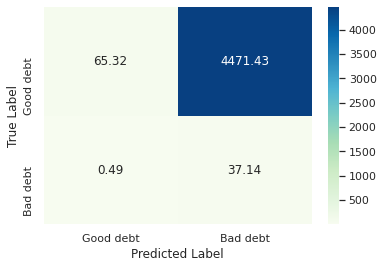

In [3661]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['Good debt', 'Bad debt']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C,annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [3662]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predict,target_names=target_names))

              precision    recall  f1-score   support

   Good debt       0.99      0.65      0.79      4513
    Bad debt       0.01      0.37      0.02        35

    accuracy                           0.65      4548
   macro avg       0.50      0.51      0.40      4548
weighted avg       0.99      0.65      0.78      4548



**Deep learning**

In [3663]:
import tensorflow as tf
tf.compat.v1.reset_default_graph() # Clear Model 
np.random.seed(1) # Fix Randomness 
tf.compat.v1.random.set_random_seed(1) # Fix Randomness

#model แบบ sequential เดินไปข้างหน้าอย่างเดียว  deep learning อย่างง่าย
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(8, activation='relu',  input_shape=(11,)), #นำเข้ามา 11 (column) ไปต่อ 8 node
  tf.keras.layers.Dense(4, activation='relu'), #จาก 8 node ไปต่อ 4 node
  tf.keras.layers.Dense(2, activation='relu'), #จาก 4 node ไปต่อ 1 node
  tf.keras.layers.Dense(1, activation='sigmoid') #ปิดด้วย sigmoid เพราะคำตอบของ label มี 2 ค่า
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________


In [3664]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 

#ใช้ algorithm ชื่อ adam
#ใช้ binary_crossentropy เพราะคำตอบของ label มีแค่ 2 ค่า

Training

In [3665]:
train_acc = list()
val_acc = list()
for i in range(0,185):
  history = model.fit(X_train_norm, y_train, epochs= 1, batch_size = 300, validation_data= (X_val_norm, y_val))
  tmp_avg = np.mean(history.history['accuracy'])
  tmp_avg_val = np.mean(history.history['val_accuracy'])
  train_acc.append(tmp_avg)
  val_acc.append(tmp_avg_val)

#batch_size คือ เอาข้อมูลเข้าไป train ทีละเท่าไหร่

1/1 [==============================] - 0s 129ms/step - loss: 0.6355 - accuracy: 0.7164 - val_loss: 0.7237 - val_accuracy: 0.6275


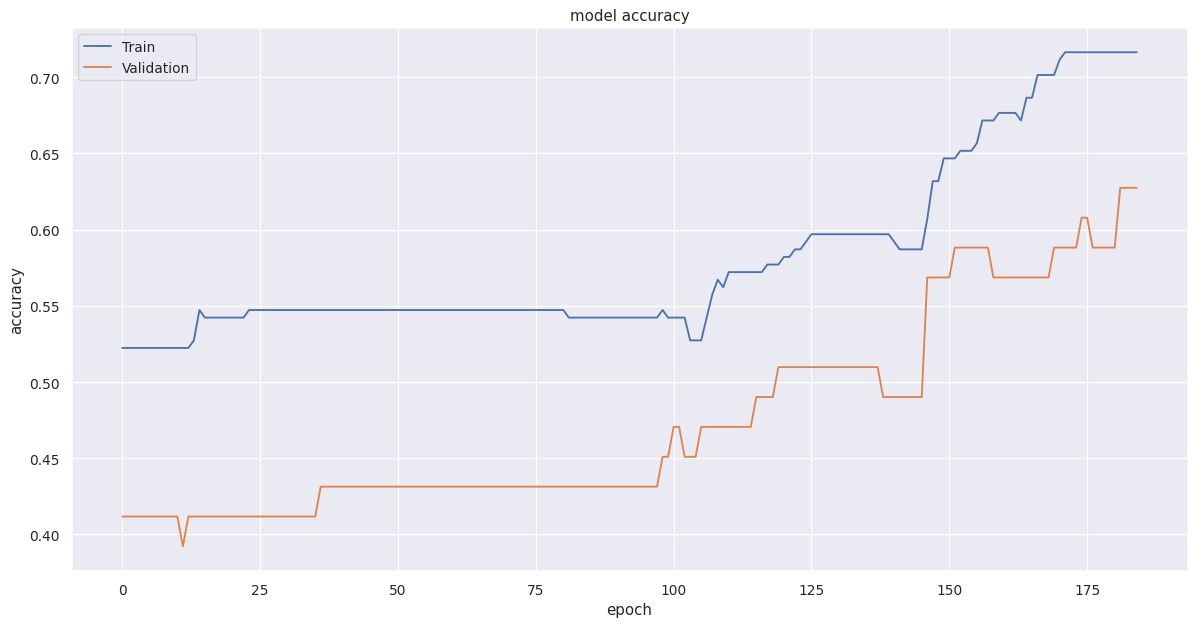

In [3666]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(num=None, figsize=(16, 8), dpi=90, facecolor='w', edgecolor='k')
plt.plot()
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Testing

In [3667]:
y_predict = np.round(model.predict(X_test_norm))
y_predict = [i[0] for i in y_predict.tolist()]
sum(y_predict == y_test)/len(y_test)

0.7695690413368513

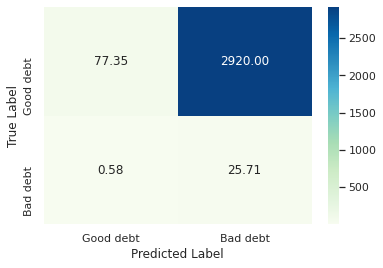

In [3668]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['Good debt', 'Bad debt']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [3669]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predict,target_names=target_names))

              precision    recall  f1-score   support

   Good debt       0.99      0.77      0.87      4513
    Bad debt       0.01      0.26      0.02        35

    accuracy                           0.77      4548
   macro avg       0.50      0.52      0.44      4548
weighted avg       0.99      0.77      0.86      4548

